# **Sentiment Analysis** of the **Restaurant Reviews** from **YELP** Dataset

## **Frequency-based** and **word embeddings** techniques

### - Bag-of-words and TF-IDF

### - Word2Vec and Doc2Vec

#### Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score,f1_score,precision_score, recall_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import sys
import os
import warnings


In [2]:
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" 

#### Read the **cleaned** dataset stored in the bucket at the **end** of the **preprocesssing** phase

In [3]:
df_final = pd.read_csv('gs://demo2222/df_final.csv')

#### Train/test split **keeping** the two **columns of interest** and **preserve** the **same proportions** of examples in **each class** as **observed** in the **original dataset**

In [4]:
X = df_final['cleaned_reviews'] 
y = df_final['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, stratify=y)

In [5]:
X_train.head()

3660    journeyman want like try hard consider restaur...
1395    sad old chef leave start come delicious menu c...
7620    come familiar expect parent surprised generous...
5904    aldo server excellent attentive point come cel...
9029    good chinese town order time count hand sesame...
Name: cleaned_reviews, dtype: object

In [6]:
X_train.shape

(6500,)

In [7]:
X_train.isnull().any().any()

False

In [8]:
y_train.head()

3660    0.0
1395    0.0
7620    1.0
5904    1.0
9029    1.0
Name: sentiment, dtype: float64

In [9]:
y_train.shape

(6500,)

#### UDF for **evaluating** models


In [10]:
def evaluate(y_test, predictions):
    cf_matrix = confusion_matrix(y_test, predictions)
    sns.heatmap(cf_matrix, annot = True, fmt = 'd',cmap="Blues")
    plt.title('Heatmap of confusion matrix for Test data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 
    
    
    print("Precision Score of the model:", precision_score(y_test,predictions)*100)
    print("Recall Score of the model:", recall_score(y_test,predictions)*100)
    print("Acuracy score of the model:",accuracy_score(y_test,predictions)*100)
    print("F1 score of the model:",f1_score(y_test,predictions)*100)

###  **Bag-of-Words**: establishing a benchmark with baseline classifier models

#### We can use a **pipeline** like below to **find out** which **ngram_range performs better** with the **logistic regression classifier**

Best ngram_range: (1, 3)
Precision Score of the model: 98.74538745387453
Recall Score of the model: 96.05168700646087
Acuracy score of the model: 97.4156496769562
F1 score of the model: 97.37991266375545


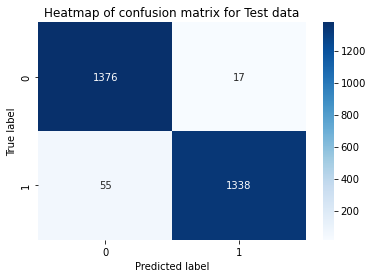

In [11]:
param_grid = {'c_vectorizer__ngram_range': [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3)]}

lr_pipeline = Pipeline([
    ('c_vectorizer', CountVectorizer()),
    ('lr', LogisticRegression(random_state=42))
])


grid_search_lr = GridSearchCV(lr_pipeline, cv=2, param_grid=param_grid, scoring='f1')
grid_search_lr.fit(X_train, y_train)

print('Best ngram_range:', grid_search_lr.best_estimator_.get_params()['c_vectorizer__ngram_range'])

predictions = grid_search_lr.predict(X_test)
evaluate(y_test, predictions )


#### We can use a **pipeline** like below to **find out** which **ngram_range performs better** for with the **SVM**

Best ngram_range: (1, 2)
Precision Score of the model: 97.22425127830533
Recall Score of the model: 95.5491744436468
Acuracy score of the model: 96.41062455132807
F1 score of the model: 96.37943519188993


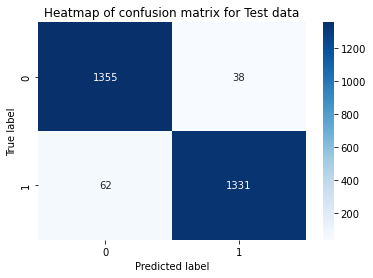

In [12]:
param_grid = {'c_vectorizer__ngram_range': [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3)]}

svm_pipe = Pipeline([
 ('c_vectorizer', CountVectorizer()),
 ('svm', svm.SVC(max_iter=-1, random_state=123))
])

grid_search_svm = GridSearchCV(svm_pipe, cv=2, param_grid=param_grid, scoring='f1')
grid_search_svm.fit(X_train, y_train)

print('Best ngram_range:', grid_search_svm.best_estimator_.get_params()['c_vectorizer__ngram_range'])

predictions = grid_search_svm.predict(X_test)
evaluate(y_test, predictions )


#### **Evaluation** using **Logistic Regression** classifier with **Hyperparameter tuning** 

Best l1_ratio: none
Best C: 1
Best penalty: l2
Best solver: lbfgs
Precision Score of the model: 98.74538745387453
Recall Score of the model: 96.05168700646087
Acuracy score of the model: 97.4156496769562
F1 score of the model: 97.37991266375545


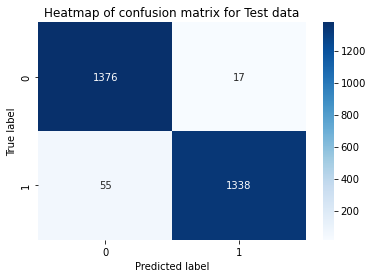

In [13]:
grid = {"lr__C":[0.5, 1, 2], 'lr__l1_ratio':['none', 0, 0.1], 'lr__penalty':['l2', 'elasticnet'],
       'lr__solver':['lbfgs', 'saga']}

# Pipeline for CountVectorizer - with the best ngram_range - and Logistic Regression
lr_pipe_2 = Pipeline([
 ('c_vectorizer', CountVectorizer(ngram_range = (1,3))),
 ('lr', LogisticRegression(max_iter=1500, random_state=42))
])

logreg_cv=GridSearchCV(lr_pipe_2, grid, scoring='f1', cv=2)
logreg_cv.fit(X_train, y_train)

print('Best l1_ratio:', logreg_cv.best_estimator_.get_params()['lr__l1_ratio'])
print('Best C:', logreg_cv.best_estimator_.get_params()['lr__C'])
print('Best penalty:', logreg_cv.best_estimator_.get_params()['lr__penalty'])
print('Best solver:', logreg_cv.best_estimator_.get_params()['lr__solver'])

predictions = logreg_cv.predict(X_test)
evaluate(y_test, predictions )

#### **Evaluation** using **SVM** classifier with **Hyperparameter tuning** 

Best KERNEL: rbf
Best C: 3
Precision Score of the model: 98.17518248175182
Recall Score of the model: 96.55419956927494
Acuracy score of the model: 97.37975592246949
F1 score of the model: 97.35794426348173


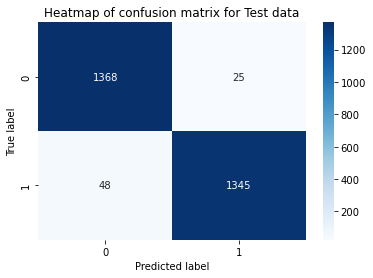

In [14]:
param_grid_svm = [
    {'svm__kernel':('linear', 'rbf')},
    {'svm__C':[1, 2, 3, 4]},
]    

# Pipeline for CountVectorizer - with the best ngram_range - and SVM Classifier 
svm_pipe_2 = Pipeline([
 ('c_vectorizer', CountVectorizer(ngram_range = (1,2))),
 ('svm',svm.SVC(random_state=123))
])

svm_model_cv = GridSearchCV(svm_pipe_2, param_grid_svm)

svm_model_cv.fit(X_train, y_train)

print('Best KERNEL:', svm_model_cv.best_estimator_.get_params()['svm__kernel'])
print('Best C:', svm_model_cv.best_estimator_.get_params()['svm__C'])


predictions = svm_model_cv.predict(X_test)
evaluate(y_test, predictions )

###  TF-IDF: establishing a benchmark with baseline classifier models

#### We can use a **pipeline** like below to **find out** which **ngram_range performs better** for the **logistic regression**

Best ngram_range: (1, 2)
Precision Score of the model: 96.97416974169741
Recall Score of the model: 94.32878679109835
Acuracy score of the model: 95.69274946159368
F1 score of the model: 95.63318777292577


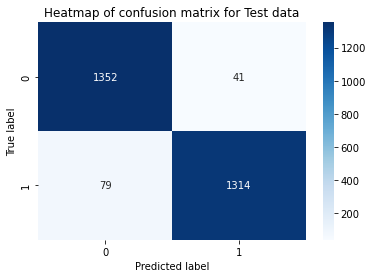

In [15]:
param_grid = {'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3)]}

lr_pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=1500, random_state=42))
])


logreg_cv_2 = GridSearchCV(lr_pipe_tfidf, cv=2, param_grid=param_grid, scoring='f1')
logreg_cv_2.fit(X_train, y_train)

print('Best ngram_range:', logreg_cv_2.best_estimator_.get_params()['tfidf__ngram_range'])

predictions = logreg_cv_2.predict(X_test)
evaluate(y_test, predictions )

#### We can use a **pipeline** like below to **find out** which **ngram_range performs better** for with the **SVM**

Best ngram_range: (1, 1)
Precision Score of the model: 98.40232389251997
Recall Score of the model: 97.27207465900933
Acuracy score of the model: 97.84637473079684
F1 score of the model: 97.83393501805054


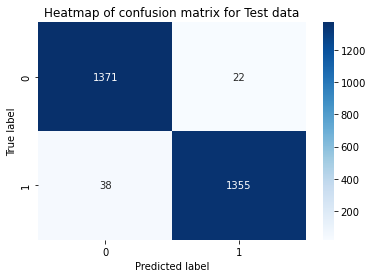

In [16]:
param_grid = {'tfidf__ngram_range': [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3)]}

svm_pipe_tfidf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('svm', svm.SVC(max_iter=-1, random_state=123)),
])

svm_model_cv_2 = GridSearchCV(svm_pipe_tfidf, cv=2, param_grid=param_grid, scoring='f1')
svm_model_cv_2.fit(X_train, y_train)

print('Best ngram_range:', svm_model_cv_2.best_estimator_.get_params()['tfidf__ngram_range'])

predictions = svm_model_cv_2.predict(X_test)
evaluate(y_test, predictions )

#### **Evaluation** using **Logistic Regression** classifier with **Hyperparameter tuning** 

Best l1_ratio: none
Best C: 30
Best penalty: l2
Best solver: saga
Precision Score of the model: 99.0377498149519
Recall Score of the model: 96.05168700646087
Acuracy score of the model: 97.5592246949031
F1 score of the model: 97.52186588921283


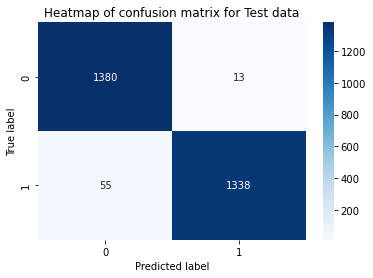

In [17]:
grid = {"lr__C":[1, 10, 20, 30, 40], 'lr__l1_ratio':['none', 0, 0.1], 'lr__penalty':['l2', 'elasticnet'],
       'lr__solver':['lbfgs', 'saga']}

# Pipeline for TfidfVectorizer - with the best ngram_range - and Logistic Regression Classifier 
lr_pipe_tfidf_2 = Pipeline([
 ('tfidf', TfidfVectorizer(ngram_range = (1,2))),
 ('lr', LogisticRegression(max_iter=1500, n_jobs = -1, random_state=42))
])

logreg_cv_3=GridSearchCV(lr_pipe_tfidf_2, grid, scoring='f1', cv=2)
logreg_cv_3.fit(X_train, y_train)

print('Best l1_ratio:', logreg_cv_3.best_estimator_.get_params()['lr__l1_ratio'])
print('Best C:', logreg_cv_3.best_estimator_.get_params()['lr__C'])
print('Best penalty:', logreg_cv_3.best_estimator_.get_params()['lr__penalty'])
print('Best solver:', logreg_cv_3.best_estimator_.get_params()['lr__solver'])

predictions = logreg_cv_3.predict(X_test)
evaluate(y_test, predictions )


#### **Evaluation** using **SVM** classifier with **Hyperparameter tuning** 

Best KERNEL: rbf
Best C: 1.5
Precision Score of the model: 98.61918604651163
Recall Score of the model: 97.4156496769562
Acuracy score of the model: 98.02584350323043
F1 score of the model: 98.01372336583604


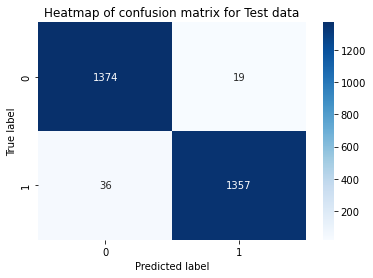

In [18]:
param_grid_svm = [
    {'svm__kernel':('linear', 'rbf')},
    {'svm__C':[ 0.5, 1, 1.5, 1.9]},
]    

# Pipeline for TfidfVectorizer - with the best ngram_range - and SVM Classifier 

svm_pipe_tfidf_2 = Pipeline([
 ('tfidf', TfidfVectorizer(ngram_range = (1,1))),
 ('svm',svm.SVC(random_state=123))
])

svm_model_cv_3 = GridSearchCV(svm_pipe_tfidf_2, param_grid_svm, cv=2)

svm_model_cv_3.fit(X_train, y_train)

print('Best KERNEL:', svm_model_cv_3.best_estimator_.get_params()['svm__kernel'])
print('Best C:', svm_model_cv_3.best_estimator_.get_params()['svm__C'])

predictions = svm_model_cv_3.predict(X_test)
evaluate(y_test, predictions )

### Word2Vec Model

In [19]:
train_cleaned_reviews = X_train.str.split() # tokenization
test_cleaned_reviews = X_test.str.split() # tokenization

#### **Word2Vec** without using pretrained word embeddings can be more **suitable** if one wants to create word embeddings using a **customized dataset**. This allows the model to **learn contextual embeddings properly** during the **training phase** and **performs better** on **unseen data**. 

#### Word2Vec model with default parameters except for the number of features (500) given the **vast** corpus

In [20]:

number_of_features = 500
model_w2v = Word2Vec(
            train_cleaned_reviews,
            size=number_of_features, # nmumber of features
            window=5, # window size
            min_count=5, # Ignores all words with total frequency lower than 5.                                  
            sg = 1, # 1 for skip-gram model
            hs = 0, # negative sampling will be used
            negative = 10, # > 0, for negative sampling
            workers= 4, # number of cores
            seed = 42 
) 

model_w2v.train(train_cleaned_reviews, total_examples= len(X_train), epochs=20)

(5047737, 5926340)

#### UDF to **get the vectors** that will **feed** the **classifiers**

In [21]:
def getVectors(dataset):
  word_Embedding=np.zeros(number_of_features) 
  vectors=[]
  for review in dataset:
    wordCount=0
    # Loop over each word in the review and, if it is in the model's vocaublary, add its feature vector to the total
    for word in review: 
      if word in model_w2v.wv.vocab: # model_w2v.wv.vocab is a list that contains the names of the words in the model's vocabulary
        word_Embedding=word_Embedding+model_w2v.wv[word] 
        wordCount=wordCount+1
  
    word_Embedding=word_Embedding/wordCount  # Get the average
    vectors.append(word_Embedding)
  return vectors

trainReviewVectors=getVectors(train_cleaned_reviews)
testReviewVectors=getVectors(test_cleaned_reviews)

#### **Word2Vec**: establishing a benchmark with baseline classifier models

#### **Evaluation** using **Logistic Regression** baseline model

Precision Score of the model: 91.47121535181236
Recall Score of the model: 92.39052404881551
Acuracy score of the model: 91.88801148600143
F1 score of the model: 91.92857142857143


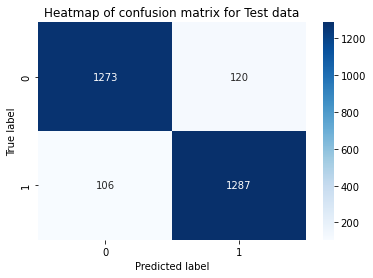

In [22]:
model_lr = LogisticRegression(random_state=42)
model_lr.fit(trainReviewVectors, y_train)
predictions = model_lr.predict(testReviewVectors)
evaluate(y_test, predictions)

#### **Evaluation** using **SVM** baseline model

Precision Score of the model: 93.06151645207439
Recall Score of the model: 93.39554917444364
Acuracy score of the model: 93.21608040201005
F1 score of the model: 93.22823360802579


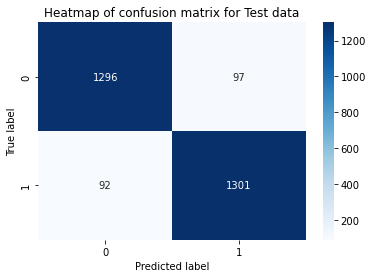

In [23]:
model_svm = svm.SVC(random_state=42)
model_svm.fit(trainReviewVectors, y_train)
predictions = model_svm.predict(testReviewVectors)
evaluate(y_test, predictions)

#### **Hyperparemeter tunning** for **Logistic Regression** Classifier

Best C: 30
Best l1_ratio: none
Best penalty: l2
Best solver: saga
Precision Score of the model: 92.83128167994207
Recall Score of the model: 92.03158650394832
Acuracy score of the model: 92.46231155778895
F1 score of the model: 92.42970439798125


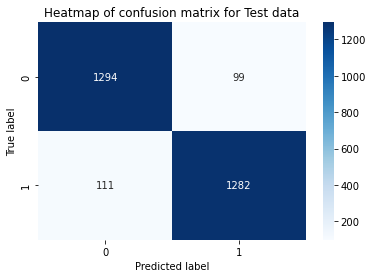

In [24]:
grid_lr_word2vec = {"C":[1, 10, 20, 30, 50], 'l1_ratio':['none', 0, 0.1], 'penalty':['l2', 'elasticnet'],
                'solver':['lbfgs', 'saga']}

lr_word2vec = LogisticRegression(max_iter=1500, random_state=42)

logreg_cv_word2vec=GridSearchCV(lr_word2vec, grid_lr_word2vec, n_jobs=-1)
logreg_cv_word2vec.fit(trainReviewVectors, y_train)

print('Best C:', logreg_cv_word2vec.best_estimator_.get_params()['C'])
print('Best l1_ratio:', logreg_cv_word2vec.best_estimator_.get_params()['l1_ratio'])
print('Best penalty:', logreg_cv_word2vec.best_estimator_.get_params()['penalty'])
print('Best solver:', logreg_cv_word2vec.best_estimator_.get_params()['solver'])


predictions = logreg_cv_word2vec.predict(testReviewVectors)
evaluate(y_test, predictions )

#### **Hyperparemeter tunning** for **SVM** Classifier

Best KERNEL: rbf
Best C: 25
Precision Score of the model: 97.79735682819384
Recall Score of the model: 95.62096195262025
Acuracy score of the model: 96.73366834170855
F1 score of the model: 96.69691470054447


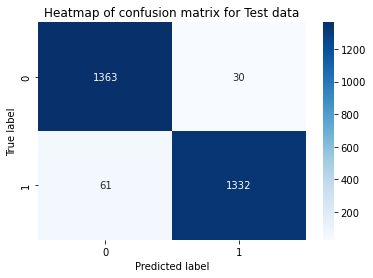

In [25]:
# Hyperparameter tuning com SVM 

grid_svm_word2vec = [
    {'kernel':('linear', 'rbf')},
    {'C':[ 1, 10, 20, 25, 30]},
]    

svm_word2vec = svm.SVC(random_state=42)


svm_word2vec_cv = GridSearchCV(svm_word2vec, grid_svm_word2vec, n_jobs=-1)

svm_word2vec_cv.fit(trainReviewVectors, y_train)

print('Best KERNEL:', svm_word2vec_cv.best_estimator_.get_params()['kernel'])
print('Best C:', svm_word2vec_cv.best_estimator_.get_params()['C'])

predictions = svm_word2vec_cv.predict(testReviewVectors)
evaluate(y_test, predictions)

### **Doc2Vec** model

#### To keep **features** and **labels** in only **two** datasets, let's concatenate X_train and y_train into a **train set**, and X_test and y_test into a **test set**.

In [26]:
train = pd.concat([X_train, y_train], axis=1) # Explicar que é para juntar para serem 2 colunas a serem treinadas
train = train.reset_index(drop=True)
test = pd.concat([X_test, y_test], axis=1)
test = test.reset_index(drop=True)
train.shape

(6500, 2)

In [27]:
train.head()

,cleaned_reviews,sentiment
0,journeyman want like try hard consider restaur...,0.0
1,sad old chef leave start come delicious menu c...,0.0
2,come familiar expect parent surprised generous...,1.0
3,aldo server excellent attentive point come cel...,1.0
4,good chinese town order time count hand sesame...,1.0


In [28]:
train.columns

Index(['cleaned_reviews', 'sentiment'], dtype='object')

In [29]:
train_tagged =  [TaggedDocument((train['cleaned_reviews'].str.split(' ')[i]), [train['sentiment'].loc[i]]) for i in range(len(train))]
test_tagged =  [TaggedDocument((test['cleaned_reviews'].str.split(' ')[i]), [test['sentiment'].loc[i]]) for i in range(len(test))]

In [30]:
train_tagged[0] # example with the first review of the train set

TaggedDocument(words=['journeyman', 'want', 'like', 'try', 'hard', 'consider', 'restaurant', 'literally', 'minute', 'house', 'neighbor', 'love', 'union', 'square', 'refinement', 'journeyman', 'purportedly', 'bring', 'definitely', 'overdue', 'work', 'paper', 'restaurant', 'love', 'local', 'modern', 'inventive', 'casual', 'reality', 'restaurant', 'seriously', 'despite', 'disappointing', 'dining', 'experience', 'glad', 'return', 'hub', 'celebrate', 'wedding', 'anniversary', 'opt', 'course', 'omnivore', 'menu', 'add', 'serving', 'foie', 'gra', 'confit', 'veal', 'tongue', 'smoke', 'beef', 'heart', 'course', 'menu', 'consist', 'spring', 'salad', 'favas', 'pea', 'spinach', 'carrot', 'spring', 'foam', 'serve', 'purpose', 'asparagus', 'soy', 'bonito', 'sous', 'vide', 'black', 'cod', 'leek', 'puree', 'potato', 'veal', 'breast', 'sweetbread', 'artichoke', 'dessert', 'cane', 'sugar', 'include', 'macaron', 'shoofly', 'pie', 'different', 'thing', 'amuse', 'offer', 'warm', 'lentil', 'salad', 'gruyere

#### Doc2Vec Model using **negative smapling** with default parameters except for the number of features (500) given the **vast corpus** 

In [31]:
model_dbow = Doc2Vec(dm=1, vector_size=500, workers=4, hs=0, negative=5, seed=123)
model_dbow.build_vocab(train_tagged)

In [32]:
model_dbow.train(train_tagged, total_examples=len(train_tagged), epochs=10)

#### Building the **Final Vector Feature** for the Classifier


In [33]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(list(doc.words))) for doc in sents])
    return targets, regressors

In [34]:
y_train_tagged, X_train_tagged = vec_for_learning(model_dbow, train_tagged)
y_test_tagged, X_test_tagged = vec_for_learning(model_dbow, test_tagged)

#### Using **Logistic Regression** classifier: baseline model

Precision Score of the model: 90.25089605734767
Recall Score of the model: 90.38047379755922
Acuracy score of the model: 90.30868628858578
F1 score of the model: 90.31563845050215


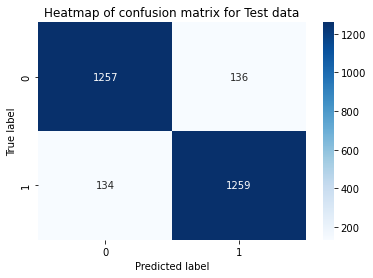

In [35]:
model_lr = LogisticRegression(max_iter=100, random_state=123)
model_lr.fit(X_train_tagged, y_train_tagged)
predictions = model_lr.predict(X_test_tagged)
evaluate(y_test_tagged, predictions )

#### Using **SVM** classifier: baseline model

Precision Score of the model: 91.02099927588704
Recall Score of the model: 90.23689877961235
Acuracy score of the model: 90.66762383345298
F1 score of the model: 90.62725306416726


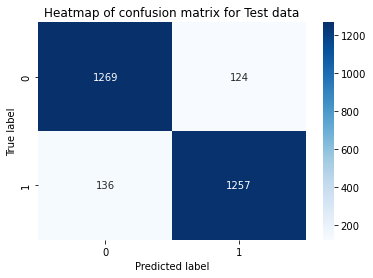

In [36]:
model_svm = svm.SVC(max_iter=-1, random_state=42) 
model_svm.fit(X_train_tagged, y_train_tagged)
predictions = model_svm.predict(X_test_tagged)
evaluate(y_test_tagged, predictions)

#### **Hyperparemeter tunning** for **Logistic Regression** Classifier 

Best C: 1.7
Best l1_ratio: none
Best penalty l2
Best solver: lbfgs
Precision Score of the model: 90.51042415528397
Recall Score of the model: 90.38047379755922
Acuracy score of the model: 90.45226130653266
F1 score of the model: 90.44540229885058


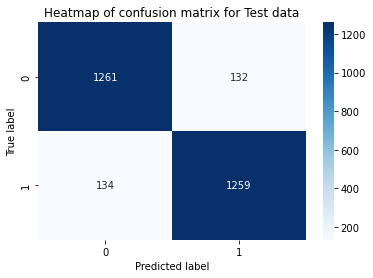

In [37]:
grid_doc2vec_lr = {"C":[1, 1.5, 1.7, 1.8], 'l1_ratio':['none', 0, 0.1], 'penalty':['l2', 'elasticnet'],
       'solver':['lbfgs', 'saga']}

model_lr = LogisticRegression(max_iter=100, random_state=123) 
logreg_cv_doc2vec=GridSearchCV(model_lr, grid_doc2vec_lr, cv=2, n_jobs=-1)
logreg_cv_doc2vec.fit(X_train_tagged, y_train_tagged)

print('Best C:', logreg_cv_doc2vec.best_estimator_.get_params()['C'])
print('Best l1_ratio:', logreg_cv_doc2vec.best_estimator_.get_params()['l1_ratio'])
print('Best penalty', logreg_cv_doc2vec.best_estimator_.get_params()['penalty'])
print('Best solver:', logreg_cv_doc2vec.best_estimator_.get_params()['solver'])


predictions = logreg_cv_doc2vec.predict(X_test_tagged)
evaluate(y_test_tagged, predictions)

#### **Hyperparemeter tunning** for **SVM** Classifier 

Best KERNEL: rbf
Best C: 4
Precision Score of the model: 91.66666666666666
Recall Score of the model: 90.02153625269203
Acuracy score of the model: 90.91888011486002
F1 score of the model: 90.83665338645417


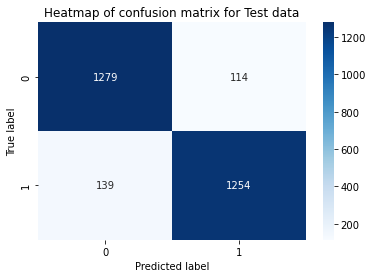

In [38]:
grid_doc2vec_svm = [
    {'kernel':('linear', 'rbf')},
    {'C':[ 1, 4, 8, 12, 16, 20]},
]    

svm_model = svm.SVC(random_state=42)


svm_model_cv_doc2vec = GridSearchCV(svm_model, grid_doc2vec_svm, n_jobs=-1)

svm_model_cv_doc2vec.fit(X_train_tagged, y_train_tagged)

print('Best KERNEL:', svm_model_cv_doc2vec.best_estimator_.get_params()['kernel'])
print('Best C:', svm_model_cv_doc2vec.best_estimator_.get_params()['C'])

predictions = svm_model_cv_doc2vec.predict(X_test_tagged)
evaluate(y_test_tagged, predictions)

#### **Conclusions**: 
#### - For **all** models **F1 scores** have **high values** (> 90%).
#### - **All tuned** models have **higher values** for **F1 score** than the **corresponding baseline** models, as **expected** (with the exception of Logistic Regression with CountVectorizer, we got the same value for the baseline model and for the tuned model) .
#### - The **best F1 score** were achieved using **TF-IDF** and the **SVM** classifier with **hyperparameter tuning** (just above 98%). 